<h1><center>Emoji'on : Reconnaissance des émotions</center></h1>
<h2><center>Part 3 : Deep Learning (CNN)</center></h2>
<center><img src="https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2F32cf5db1-69d0-4e21-8dec-710068e7a355.jpg&w=1280&q=75" alt="iIllustration" title="title"  style="object-fit:cover; width:800px; height:250px;"/></center>

> __*Created by Charley lebarbier*__

## Objectives :  
*Réaliser une application pour placer des émojis sur le visage de personnes détectés dans une vidéo en fonction de leur émotion.*  

## Livrables :  

- Notebook cohérent sur :  
    - l'analyse, 
    - la préparation des données, la création et l'entrainement du/des modèles et visualisation des performances  
</br>
- Application fonctionnelle

-----------------
-----------------

## Prepare the workspace

In [7]:
# -- General Import
import keras
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

# -- Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory, to_categorical

# -- Other
from livelossplot import PlotLossesKeras
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
## -------------- Data Load -------------- ##
df = pd.read_csv('../data/fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Prepare Dataset

In [9]:
x_train, x_val, x_test = [], [], []
y_train, y_val, y_test = [], [], []

for idx, row in df.iterrows():
    img = row['pixels'].split(" ")            # - Get the img pixel

    if row['Usage'] == 'Training':
        x_train.append(np.array(img))         # - Convert img in array
        y_train.append(row['emotion'])        # - Get the img label

    elif row['Usage'] == 'PublicTest':
        x_val.append(np.array(img))
        y_val.append(row['emotion'])

    elif row['Usage'] == 'PrivateTest':
        x_test.append(np.array(img))
        y_test.append(row['emotion'])

In [10]:
# -- Convert in array for next step
x_train = np.array(x_train, dtype='float')
y_train = np.array(y_train)

x_val = np.array(x_val, dtype='float')
y_val = np.array(y_val)

x_test = np.array(x_test, dtype='float')
y_test = np.array(y_test)

In [11]:
# -- Reshape at the proper form for the model i.e. add 3 other dimensions
# -- 48, 48 (size of img) and 1 for the channel because graymode
# -- Then normalize it

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1) / 255.0
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1) / 255.0
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1) / 255.0


# -- Reshape the target with the number of category

y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

## CNN

In [12]:
input_shape = (48, 48, 1)       # img size 48px on 48px, 1 channel = Grayscale
batch_size = 64

### Training / Validation

Pour notre modèle, nous avons utilisé les 5 éléments qu'on retrouvait dans un certain nombre de tutoriels et kaggle, c'est-à-dire : Conv2D, BatchNormalization, MaxPooling2D, Dropout et Dense.  
</br>
Pour construire notre architecture, nous l'avons construit en 4 ensemble prenant la construction suivante :  
- Conv2D  
- BatchNormalization  
- Conv2D  
- BatchNormalization  
- MaxPooling2D  
- Dropout  
</br>
Pour chaque lot nous doublons le nombre de filtre (64 à 512) pour affiner le modèle avant d'applatir et revenir sur un filtre de 128.  
</br> 
Par ailleurs, nous avons fait le choix de l'activation 'elu', plutôt que 'ReLu' qui a l'avantage d'améliorer les performances d'entraînement en utilisant une fonction exponentiel pour la partie négative et non plus une fonction linéaire. Egalement, pour initialiser les poids des neurones, nous avons fait le choix du mode 'he_normal', qui est calculé sur la base d'échantillon aléatoire tiré de la loi normale (stddev = sqrt(2 / fan_in) fan_in étant le nombre d'entrée sur le tensor).

In [15]:
cnn_model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, (5,5), input_shape=input_shape, activation='elu',
         padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5,5), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(256, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(512, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3,3), activation='elu', padding='same', 
        kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),

    tf.keras.layers.Dense(7, activation='softmax')
])

# -- Compilation
cnn_model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# -- Model Architecture
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

In [16]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          verbose = 1,
                          restore_best_weights = True,
                          mode = "min",
                          patience = 5),

checkpoint = ModelCheckpoint('best_ann_model.h5',
                             monitor = "val_loss",
                             verbose = 1,
                             save_best_only = True,
                             mode = "min"),

callbacks = [earlystop, checkpoint, PlotLossesKeras()]

In [ ]:
## -- Décommenter pour calculer sinon utiliser le load ci-dessous


# essay_ann_1 = ann_model.fit(
#         x_train,
#         y_train,
#         validation_data = (x_val, y_val),

#         epochs = 100,
#         batch_size = batch_size,

#         verbose = 1,
#         callbacks = callbacks,
# )

Pour éviter les temps de calcul via le cpu, nous avons utilisé Colab pour switcher sur le GPU est ainsi gagner en temps d'exécution. Nous chargeons ici le modèle pré-entraîné pour la suite du notebook.

Infos Google Colab après entraînement :  
*"loss: 0.7152 - accuracy: 0.7397 - val_loss: 1.0437 - val_accuracy: 0.6435"*  
*"Epoch 36: early stopping"*

In [17]:
# -- Model loading
cnn_model =  keras.models.load_model('../model_save/cnn_model.h5')

### Test

In [18]:
y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

113/113 [==============================] - 107s 926ms/step


### Metrics & Confusion Matrix

In [19]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred, digits=3, zero_division=False))

              precision    recall  f1-score   support

           0      0.532     0.580     0.555       491
           1      0.700     0.509     0.589        55
           2      0.562     0.369     0.446       528
           3      0.837     0.837     0.837       879
           4      0.506     0.530     0.518       594
           5      0.740     0.731     0.735       416
           6      0.566     0.682     0.619       626

    accuracy                          0.638      3589
   macro avg      0.635     0.606     0.614      3589
weighted avg      0.640     0.638     0.635      3589



Text(95.72222222222221, 0.5, 'Truth')

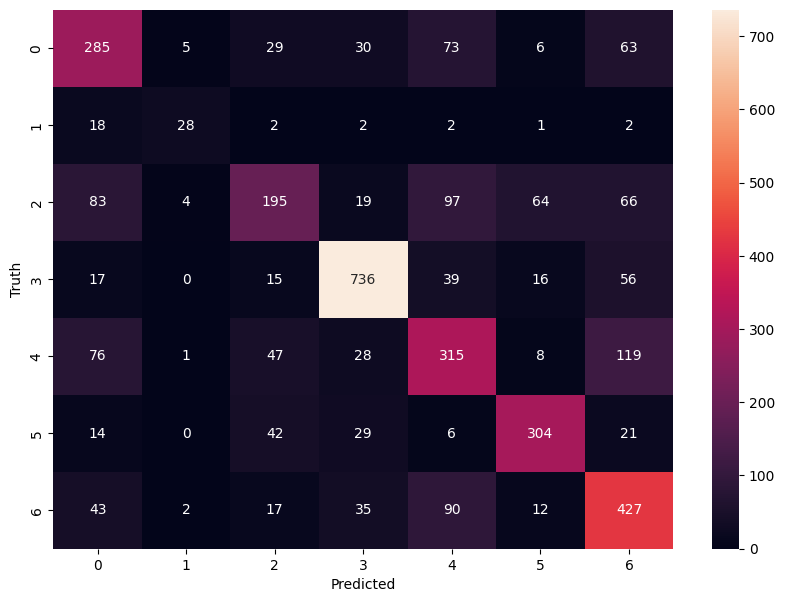

In [20]:
# -- get the x_test labels
y_actual = []

for a in y_test:
    y_actual.append(np.argmax(a))
y_actual[:10]


# -- Display the Confusion Matrix
cm = tf.math.confusion_matrix(labels=y_actual, predictions=y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Notre modèle fait un score de 63,8 % sur son jeu de test. Contrairement à l'ANN, on voit que la catégorie Disgust est déjà mieux géré. Dans l'ensemble, chaque catégorie est assez bien détecter, nous pouvons comparer la prédiction / vérité via les images pour avoir un échantillon des principales erreurs pour avoir de plus ample informations.

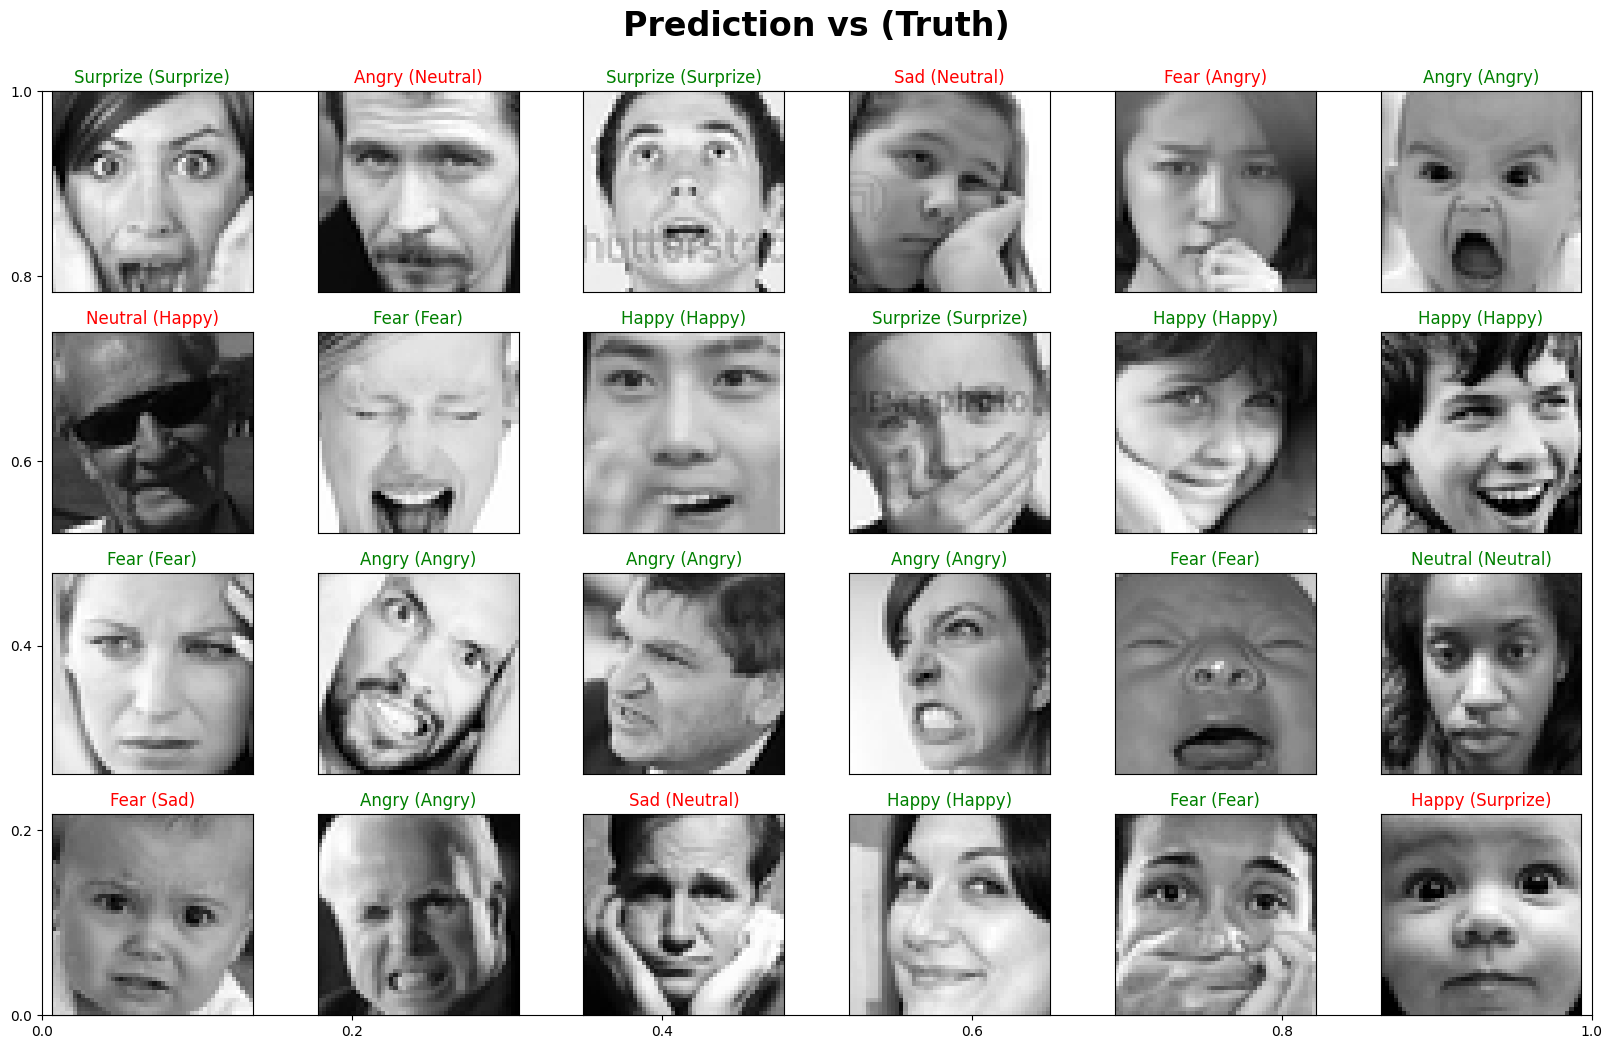

In [22]:
def check_images(x_test:np.ndarray, y_pred:np.ndarray) -> None:
    '''
    function to plot images with their lables (prediction vs (truth))
    '''

    # -- list of available emotions in the dataset
    emotions = { 0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad",
                 5:"Surprize", 6:"Neutral" }

    figure = plt.figure(figsize=(20, 12))
    plt.title("Prediction vs (Truth)",
              fontdict={'fontsize': 24, 'fontweight':'bold'}, pad=40)

    for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
        ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])

        ax.imshow(np.squeeze(x_test[index]),cmap="gray")

        predict_index = emotions[(y_pred[index])]
        true_index = emotions[np.argmax(y_test,axis=1)[index]]

        ax.set_title("{} ({})".format((predict_index), (true_index)),
                      color=("green" if predict_index == true_index else "red"))


check_images(x_test, y_pred)

Sur certaines photos, nous pouvons comprendre la confusion qu'il peut avoir. Pour améliorer les performances de notre modèle, nous allons envisager d'appliquer de la Data Augmentation afin d'avoir un Dataset comprenant un nombre similaire de données et ainsi éviter le sur ou sous entraînement sur certaines catégories.

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

## Data Augmentation

In [27]:
# -- Prepare the generators for our 2 training sets (Train and Validation)
# -- not for our test

traingen = ImageDataGenerator(
                    rotation_range = 45,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    brightness_range = [0.2, 1.0],
                    zoom_range = [0.2, 1.0],
                    horizontal_flip = True,
                    vertical_flip = True,
)

valgen = ImageDataGenerator(
                    rotation_range = 45,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    brightness_range = [0.2, 1.0],
                    zoom_range = [0.2, 1.0],
                    horizontal_flip = True,
                    vertical_flip = True,
)

In [41]:
# -- Apply to our set
traingen.fit(x_train)
valgen.fit(x_val)

train_generator = traingen.flow(x_train, y_train, batch_size=64)
val_generator = valgen.flow(x_val, y_val, batch_size=64)

3589

### Confusion Matrix

## Transfer Learning (VGG)

### Confusion Matrix